```
This notebook marks seleced fjord along the Norwegian coast
Copyright (C) 2022 - 2023 SINTEF Digital
Copyright (C) 2022 - 2023 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if p.endswith("gpuocean/src")][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 26b98e82e8d4e1ca2369cf735af8c7d3af460403 on branch reduced_gravity


# Norwegian Fjords

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import xarray as xr
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["image.origin"] = "lower"

In [3]:
def latlon2xy(lats, lons, lat, lon, dx=800.0, dy=800.0):
    penalty = (lats - lat)**2 + (lons - lon)**2
    idx_y, idx_x = np.argwhere( penalty==penalty.min() )[0]

    if lats[idx_y, idx_x] > lat:
        idx_y_lower = idx_y-1
        idx_y_upper = idx_y 
    else:
        idx_y_lower = idx_y 
        idx_y_upper = idx_y+1

    if lons[idx_y, idx_x] > lon:
        idx_x_lower = idx_x-1
        idx_x_upper = idx_x 
    else:
        idx_x_lower = idx_x  
        idx_x_upper = idx_x+1

    y = idx_y_lower + (lat - lats[idx_y_lower, idx_x])/(lats[idx_y_upper, idx_x] - lats[idx_y_lower, idx_x])
    x = idx_x_lower + (lon - lons[idx_y, idx_x_lower])/(lons[idx_y, idx_x_upper] - lons[idx_y, idx_x_lower])

    return (y-0.5)*dy/1000, (x-0.5)*dx/1000

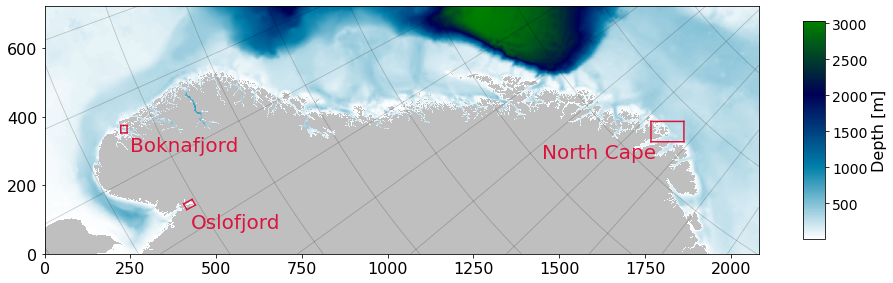

In [4]:
source_url = "/sintef/data/NorKyst800/ocean_his.an.20190716.nc"
try:
    ncfile = Dataset(source_url)
    H_full = np.array(ncfile.variables['h'])
    angle = np.array(ncfile.variables['angle'])
    lats = np.array(ncfile.variables["lat_rho"])
    lons = np.array(ncfile.variables["lon_rho"])
    land_mask = 1-ncfile["mask_rho"][:]
except Exception as e:
    raise e

finally:
    ncfile.close()

(full_ny, full_nx) = H_full.shape

# Makes sure axis are in km (assuming equidistant 800x800m grid)
extent=np.array([0, full_nx*0.8, 0, full_ny*0.8])


fig, ax = plt.subplots(figsize=(16,8))
ax.tick_params(axis='both', which='major', labelsize=16)

# Land and bathymetry
land = np.ma.masked_where(land_mask, H_full)

cmap = copy.copy(plt.cm.ocean_r)
cmap.set_bad("grey", alpha=0.5)

im = ax.imshow(land, interpolation="None", origin='lower', cmap=cmap,
            extent=extent)

cbar = fig.colorbar(im, aspect=10, shrink=0.5)
cbar.set_label('Depth [m]', size=16)
cbar.ax.tick_params(labelsize=14)

ax.contour(lons, levels = np.arange(0, 40, 4), extent=extent, colors='k', alpha=0.2, linewidths=0.8)
ax.contour(lats, levels = np.arange(56,77, 2), extent=extent, colors='k', alpha=0.2, linewidths=0.8)

red = "crimson"

# OSLO

source_url = "/sintef/data/OsloFjord/test_polstere_1h_0007.nc"

try: 
    nc = Dataset(source_url)

    ds = xr.open_dataset(source_url)
    dimY, dimX = ds.h.data.shape
    x0, x1, y0, y1 = 5, dimX-5, 175, dimY-5

    lon00 = nc["lon_rho"][y0:y1,x0:x1][ 0,-1]
    lon01 = nc["lon_rho"][y0:y1,x0:x1][ 0, 0]
    lon10 = nc["lon_rho"][y0:y1,x0:x1][-1,-1]
    lon11 = nc["lon_rho"][y0:y1,x0:x1][-1, 0]
    
    lat00 = nc["lat_rho"][y0:y1,x0:x1][ 0,-1]
    lat01 = nc["lat_rho"][y0:y1,x0:x1][ 0, 0]
    lat10 = nc["lat_rho"][y0:y1,x0:x1][-1,-1]
    lat11 = nc["lat_rho"][y0:y1,x0:x1][-1, 0]
except: 
    pass
finally:
    nc.close()

xy00 = latlon2xy(lats, lons, lat00, lon00)
xy01 = latlon2xy(lats, lons, lat01, lon01)
xy10 = latlon2xy(lats, lons, lat10, lon10)
xy11 = latlon2xy(lats, lons, lat11, lon11)

ax.plot([xy00[1],xy01[1]], [xy00[0],xy01[0]], color=red)
ax.plot([xy01[1],xy11[1]], [xy01[0],xy11[0]], color=red)
ax.plot([xy11[1],xy10[1]], [xy11[0],xy10[0]], color=red)
ax.plot([xy10[1],xy00[1]], [xy10[0],xy00[0]], color=red)

ax.annotate("Oslofjord", (425,75), fontsize=20, color=red)



# BARENTS

source_url = "/sintef/data/NorFjords160/A12/norfjords_160m_his.nc4_2020013101-2020020100"

try: 
    nc = Dataset(source_url)

    ds = xr.open_dataset(source_url)
    dimY, dimX = ds.h.data.shape
    x0, x1, y0, y1 = 1100, dimX-350, 315, dimY-585

    lon00 = nc["lon_rho"][y0:y1,x0:x1][ 0,-1]
    lon01 = nc["lon_rho"][y0:y1,x0:x1][ 0, 0]
    lon10 = nc["lon_rho"][y0:y1,x0:x1][-1,-1]
    lon11 = nc["lon_rho"][y0:y1,x0:x1][-1, 0]
    
    lat00 = nc["lat_rho"][y0:y1,x0:x1][ 0,-1]
    lat01 = nc["lat_rho"][y0:y1,x0:x1][ 0, 0]
    lat10 = nc["lat_rho"][y0:y1,x0:x1][-1,-1]
    lat11 = nc["lat_rho"][y0:y1,x0:x1][-1, 0]
except: 

    pass
finally:
    nc.close()

xy00 = latlon2xy(lats, lons, lat00, lon00)
xy01 = latlon2xy(lats, lons, lat01, lon01)
xy10 = latlon2xy(lats, lons, lat10, lon10)
xy11 = latlon2xy(lats, lons, lat11, lon11)

ax.plot([xy00[1],xy01[1]], [xy00[0],xy01[0]], color=red)
ax.plot([xy01[1],xy11[1]], [xy01[0],xy11[0]], color=red)
ax.plot([xy11[1],xy10[1]], [xy11[0],xy10[0]], color=red)
ax.plot([xy10[1],xy00[1]], [xy10[0],xy00[0]], color=red)

ax.annotate("Boknafjord", (250,300), fontsize=20, color=red)



# BOKNA

source_url = "/sintef/data/NorFjords160/A03/norfjords_160m_his.nc4_2019110101-2019110200"

try: 
    nc = Dataset(source_url)

    ds = xr.open_dataset(source_url)
    dimY, dimX = ds.h.data.shape
    x0, x1, y0, y1 = 685, dimX-360, 335, dimY-330

    lon00 = nc["lon_rho"][y0:y1,x0:x1][ 0,-1]
    lon01 = nc["lon_rho"][y0:y1,x0:x1][ 0, 0]
    lon10 = nc["lon_rho"][y0:y1,x0:x1][-1,-1]
    lon11 = nc["lon_rho"][y0:y1,x0:x1][-1, 0]
    
    lat00 = nc["lat_rho"][y0:y1,x0:x1][ 0,-1]
    lat01 = nc["lat_rho"][y0:y1,x0:x1][ 0, 0]
    lat10 = nc["lat_rho"][y0:y1,x0:x1][-1,-1]
    lat11 = nc["lat_rho"][y0:y1,x0:x1][-1, 0]
except: 

    pass
finally:
    nc.close()

xy00 = latlon2xy(lats, lons, lat00, lon00)
xy01 = latlon2xy(lats, lons, lat01, lon01)
xy10 = latlon2xy(lats, lons, lat10, lon10)
xy11 = latlon2xy(lats, lons, lat11, lon11)

ax.plot([xy00[1],xy01[1]], [xy00[0],xy01[0]], color=red)
ax.plot([xy01[1],xy11[1]], [xy01[0],xy11[0]], color=red)
ax.plot([xy11[1],xy10[1]], [xy11[0],xy10[0]], color=red)
ax.plot([xy10[1],xy00[1]], [xy10[0],xy00[0]], color=red)

ax.annotate("North Cape", (1450,280), fontsize=20, color=red)

plt.savefig("NorwegianFjords.pdf", bbox_inches="tight")